<a href="https://colab.research.google.com/github/VaneezaAhmad/Text-Prediction/blob/main/Urdu_predictive_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

There is a ton of Language modeling and Natural Language Processing work done in English and other popular languages. This project is generating the predictions of words in Urdu which is the national language of Pakistan and the is popular in South East Asia. This prediction model can be used in many ways such for creating a virtual assistant, for a search engines or keyboard predictive text or for chatbots. This can make typing easier and faster for Urdu keyboard users.

# Data Collection

Data was collected from https://www.kaggle.com/disisbig/urdu-wikipedia-articles. The author of the dataset had over 100,000 wikipedia articles in urdu. For this project only 1000 of those articles were used. 

## Import in relevant libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import spacy
import tensorflow as tf
from nltk.probability import FreqDist

from sklearn.model_selection import GridSearchCV
import pickle

from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import RMSprop

In [192]:
from bidi.algorithm import get_display
import arabic_reshaper

# Read in data

Data.py file has code to combine text files together in one file named urdu_data.txt


In [6]:
from google.colab import files
uploaded = files.upload()


Saving data.txt to data.txt


In [188]:
urdu =  open("data.txt", "r", encoding="utf_8").read()

In [189]:
len(urdu)

147477

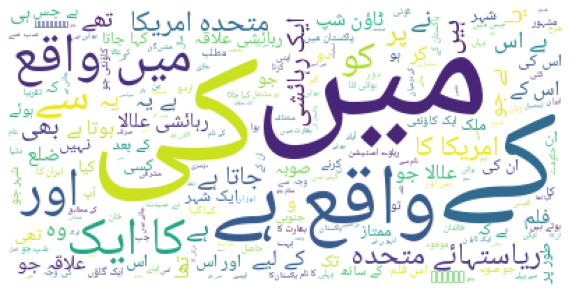

In [241]:
from ar_wordcloud import ArabicWordCloud
awc = ArabicWordCloud(background_color="white")

wc = awc.from_text(urdu)

plt.figure(figsize=(10,6))
plt.imshow(wc)
plt.axis("off")
plt.show();

# Preprocessing

## Spacy

In [9]:
nlp = spacy.blank("ur")

In [10]:
doc = nlp(urdu)

In [12]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Removal of special and unnecessary characters

In [13]:
urdu_words = [token.text for token in doc if token.text not in "′″،۔؟،ء\n-\n\n-.\n ./;:°،ء'"]


In [14]:
urdu_words = [token for token in urdu_words if token not in "،‘‘..{.,′″،/،ء'،./°،ء'.-""'-.[\‘‘؎،)‘"]


In [48]:
urdu_words = [token for token in urdu_words if token not in "·èøēŁłąśóżóțŁ'ù'ó'à'Î'é"]

In [53]:
urdu_words = [token for token in urdu_words if token not in "،،\n \n،,\n,,\n\n,,,\n\n\n,,,,\n\n\n\n\t\t\t\t\t\t\t\t\n"]

In [55]:
urdu_words = [token for token in urdu_words if token not in ")‘‘کوما': 2؛)‘‘کوما)‘‘شونین)‘‘شونین': 1"]

In [18]:
urdu_words = [token for token in urdu_words if token not in string.punctuation]

Removal of numbers and english words and letters 

In [19]:
urdu_words = [word.translate(str.maketrans('', '', '..."0123456789!+-')) \
                  for word in urdu_words]

In [20]:
urdu_words = [word.translate(str.maketrans('', '', 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')) \
                  for word in urdu_words]

In [21]:
urdu_words=[word for word in urdu_words if word != '']

In [59]:
len(urdu_words)

29153

Word cloud

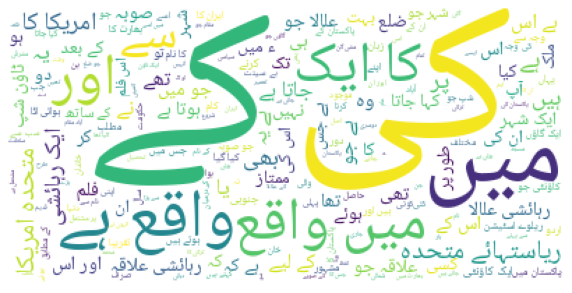

In [194]:
from ar_wordcloud import ArabicWordCloud
awc = ArabicWordCloud(background_color="white")

unique_string=(" ").join(urdu_words)
wc = awc.from_text(unique_string)

plt.figure(figsize=(10,6))
plt.imshow(wc)
plt.axis("off")
plt.show();

In [237]:
word_frequencies = {}
for word in doc:
    if word.text in urdu_words:
            if word.text not in word_frequencies.keys():
                word_frequencies[word.text] = 1
            else:
                word_frequencies[word.text] += 1

In [235]:
sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]

[('ہے', 1268),
 ('میں', 1236),
 ('کے', 943),
 ('کا', 805),
 ('ایک', 773),
 ('کی', 708),
 ('اور', 562),
 ('جو', 521),
 ('سے', 515),
 ('واقع', 477),
 ('اس', 365),
 ('ہیں', 277),
 ('پر', 210),
 ('یہ', 200),
 ('نے', 179),
 ('یا', 178),
 ('متحدہ', 169),
 ('ریاستہائے', 164),
 ('امریکا', 163),
 ('کاؤنٹی', 153)]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0, flags=flags)


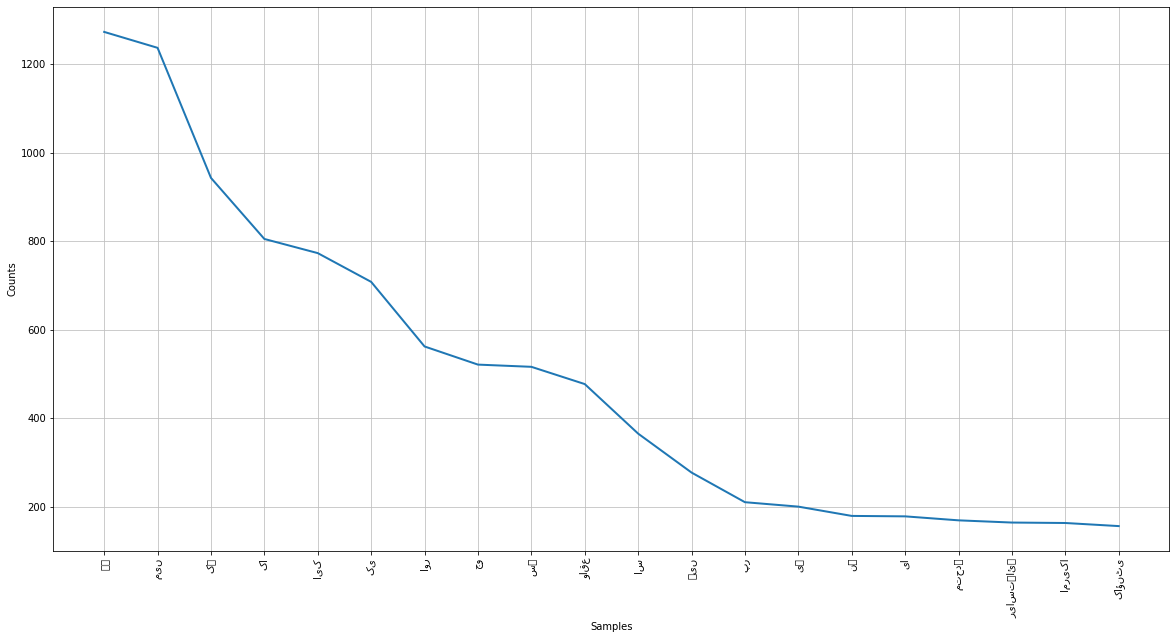

In [255]:
from nltk.probability import FreqDist

fdist = FreqDist(urdu_words)
plt.figure(figsize=(20, 10))
fdist.plot(20);

In [43]:
urdu_words[:10]

['زیورخ',
 'کیلیفورنیا',
 'ریاستہائے',
 'متحدہ',
 'امریکا',
 'کا',
 'ایک',
 'انانکارپوریٹڈ',
 'علاقہ',
 'جو']

Taking the unique words and creating a dictionary containing each word and an index for that word

In [60]:
unique_words = np.unique(urdu_words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [185]:
# unique_word_index

In [61]:
len(unique_word_index)

5778

In [62]:
unique_words[:20]

array(['ء', 'آ', 'آئر', 'آئرائی', 'آئرس', 'آئرش', 'آئرلینڈ', 'آئس', 'آئن',
       'آئون', 'آئی', 'آئینہ', 'آئیوس', 'آئیووا', 'آئیں', 'آئے', 'آب',
       'آباد', 'آبادی', 'آبادیات'], dtype='<U24')

In [66]:
np.savetxt("urdu-words.csv", unique_words, delimiter=",")
# dump(unique_words, open('uniquewords.pkl', 'wb'))

TypeError: ignored

## Separation of Target and Variables 

Taking the first three words from the list of words and making it the feature and the next word (4th word) as the target.  

In [67]:
WORD_LENGTH = 3
prev_words = []
next_words = []
for i in range(len(urdu_words) - WORD_LENGTH):
    prev_words.append(urdu_words[i:i + WORD_LENGTH])
    next_words.append(urdu_words[i + WORD_LENGTH])
print(prev_words[:5])
print(next_words[:5])

[['زیورخ', 'کیلیفورنیا', 'ریاستہائے'], ['کیلیفورنیا', 'ریاستہائے', 'متحدہ'], ['ریاستہائے', 'متحدہ', 'امریکا'], ['متحدہ', 'امریکا', 'کا'], ['امریکا', 'کا', 'ایک']]
['متحدہ', 'امریکا', 'کا', 'ایک', 'انانکارپوریٹڈ']


In [68]:
pd.DataFrame()

""


Converting the words into 0's and 1's

In [69]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    y[i, unique_word_index[next_words[i]]] = 1

In [70]:
len(X), len(y), X.shape, y.shape

(29150, 29150, (29150, 3, 5778), (29150, 5778))

# Models


## FSM

Creating a simple model with one lstm layer, one dense layer and a output layer to check the performance of the model.  

In [72]:
model = Sequential()
model.add(LSTM(32, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation("softmax"))

optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

history=model.fit(X,y, epochs=100, batch_size=64, validation_split=0.05, callbacks=[checkpoint]).history

Epoch 1/100
433/433 [==============================] - 5s 7ms/step - loss: 6.9122 - accuracy: 0.0780 - top_k_categorical_accuracy: 0.1688 - val_loss: 6.3668 - val_accuracy: 0.1591 - val_top_k_categorical_accuracy: 0.2341

Epoch 00001: loss improved from inf to 6.59522, saving model to nextword1.h5
Epoch 2/100
433/433 [==============================] - 3s 6ms/step - loss: 5.9088 - accuracy: 0.1749 - top_k_categorical_accuracy: 0.2479 - val_loss: 6.5471 - val_accuracy: 0.1866 - val_top_k_categorical_accuracy: 0.2750

Epoch 00002: loss improved from 6.59522 to 5.93074, saving model to nextword1.h5
Epoch 3/100
433/433 [==============================] - 3s 6ms/step - loss: 5.7983 - accuracy: 0.2196 - top_k_categorical_accuracy: 0.2833 - val_loss: 7.0016 - val_accuracy: 0.1797 - val_top_k_categorical_accuracy: 0.3016

Epoch 00003: loss did not improve from 5.93074
Epoch 4/100
433/433 [==============================] - 2s 6ms/step - loss: 5.8953 - accuracy: 0.2535 - top_k_categorical_accuracy

In [53]:
# model.save('urdu-modelfsm.h5')
# pickle.dump(history, open("urdu-resultsfsm.p", "wb"))

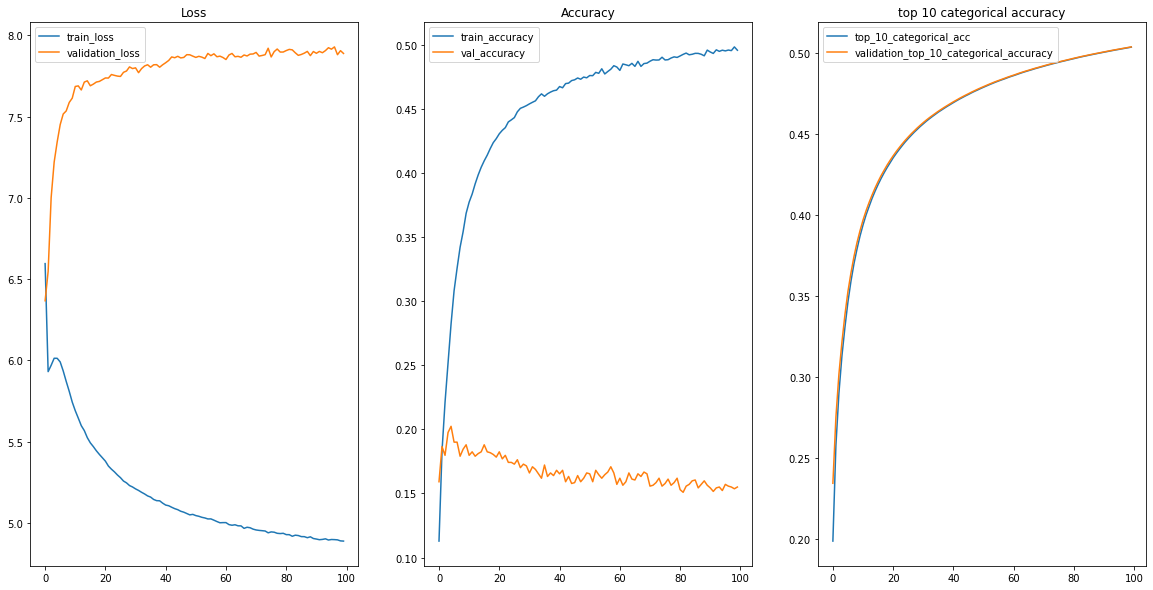

In [73]:
train_loss = history['loss']
train_acc = history['accuracy']
val_loss =history['val_loss']
val_acc = history['val_accuracy']
train_top_acc = history["top_k_categorical_accuracy"]
val_top_acc = history["val_top_k_categorical_accuracy"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.plot(train_loss, label='train_loss')
ax1.plot(val_loss, label='validation_loss')
ax1.set_title("Loss")
ax1.legend()

ax2.plot(train_acc, label='train_accuracy')
ax2.plot(val_acc, label='val_accuracy')
ax2.set_title("Accuracy")
ax2.legend()

ax3.plot(train_top_acc, label='top_10_categorical_acc')
ax3.plot(val_top_acc, label='validation_top_10_categorical_accuracy')
ax3.set_title("top 10 categorical accuracy")
ax3.legend()

The graphs above shows using the accuracy measure top_k_categoricalAccuracy that the model is doing well in regards to variance and there is a 50% chance that the target is in the top 5 predicted words. 

### graph function to display metric performance

In [105]:
def graph(results):
  train_loss = results['loss']
  train_acc = results['accuracy']
  train_top_acc = results["top_k_categorical_accuracy"]
  val_loss =results['val_loss']
  val_acc = results['val_accuracy']
  val_top_acc = results["val_top_k_categorical_accuracy"]

  fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(20, 10))

  ax1.plot(train_loss, label='train_loss')
  ax1.plot(val_loss, label='validation_loss')
  ax1.set_title("Loss")
  ax1.legend()

  # ax2.plot(train_acc, label='train_accuracy')
  # ax2.plot(val_acc, label='val_accuracy')
  # ax2.set_title("Accuracy")
  # ax2.legend()

  ax3.plot(train_top_acc, label='top_10_categorical_acc')
  ax3.plot(val_top_acc, label='validation_top_10_categorical_accuracy')
  ax3.set_title("Top 10 categorical accuracy")
  ax3.legend()

## Model 1 (2 LSTM layers, learning rate=0.001)

Adding another LSTM layer along with increasing the number of nodes. Adding two dropout layers for regularization. 

In [76]:
model1 = Sequential()
model1.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(128))
model1.add(Dropout(0.3))
model1.add(Dense(y.shape[1], activation='relu'))
model1.add(Activation("softmax"))
print(model1.summary())

optimizer = RMSprop(learning_rate=0.001)

model1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)


checkpoint1 = ModelCheckpoint("nextword2.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 128)            3024384   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5778)              745362    
_________________________________________________________________
activation_3 (Activation)    (None, 5778)              0         
Total params: 3,901,330
Trainable params: 3,901,330
Non-trainable params: 0
____________________________________________

In [77]:
results1=model1.fit(X,y, epochs=100, batch_size=64, validation_split=0.05, callbacks=[checkpoint1]).history

Epoch 1/100
433/433 [==============================] - 8s 10ms/step - loss: 8.0119 - accuracy: 0.0390 - top_k_categorical_accuracy: 0.1372 - val_loss: 7.7324 - val_accuracy: 0.0556 - val_top_k_categorical_accuracy: 0.1460

Epoch 00001: loss improved from inf to 7.87224, saving model to nextword2.h5
Epoch 2/100
433/433 [==============================] - 3s 8ms/step - loss: 7.7910 - accuracy: 0.0445 - top_k_categorical_accuracy: 0.1479 - val_loss: 7.7076 - val_accuracy: 0.0521 - val_top_k_categorical_accuracy: 0.1530

Epoch 00002: loss improved from 7.87224 to 7.77526, saving model to nextword2.h5
Epoch 3/100
433/433 [==============================] - 3s 8ms/step - loss: 7.7343 - accuracy: 0.0456 - top_k_categorical_accuracy: 0.1549 - val_loss: 7.6994 - val_accuracy: 0.0556 - val_top_k_categorical_accuracy: 0.1571

Epoch 00003: loss improved from 7.77526 to 7.75075, saving model to nextword2.h5
Epoch 4/100
433/433 [==============================] - 3s 8ms/step - loss: 7.7287 - accuracy: 

In [125]:
# model1.save('urdu-model1.h5')
pickle.dump(results1, open("urdu-results1.p", "wb"))

In [73]:
model = load_model('urdu-model1.h5')
# history = pickle.load(open("historygs.p", "rb"))

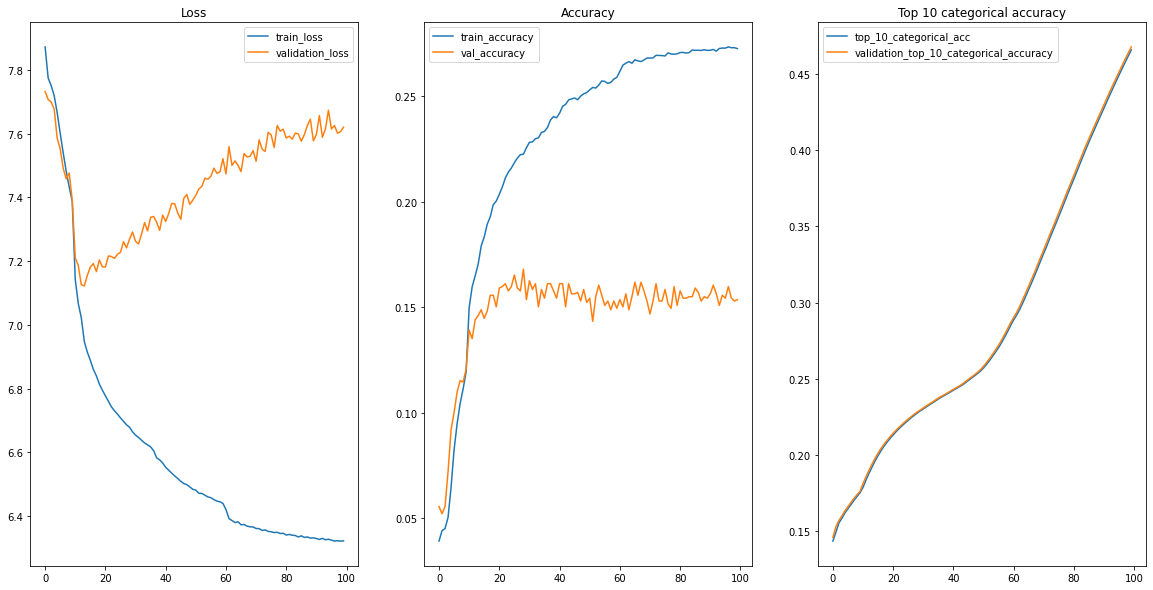

In [88]:
graph(results1)

Looking at top_k_categorical accuracy, this model performed well, with over 60% accuracy and very little variance in the training and validation set. 

## Model 2 (LSTM 256 nodes)

Increasing the number of nodes in the LSTM layers to check how the model will perform. 

In [85]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(256))
model2.add(Dropout(0.3))
model2.add(Dense(y.shape[1], activation='relu'))
model2.add(Activation("softmax"))
print(model2.summary())

optimizer = RMSprop(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)

checkpoint2 = ModelCheckpoint("nextword3.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

results2=model2.fit(X,y, epochs=100, batch_size=64, validation_split=0.05, callbacks=[checkpoint2]).history

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 3, 256)            6179840   
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5778)              1484946   
_________________________________________________________________
activation_4 (Activation)    (None, 5778)              0         
Total params: 8,190,098
Trainable params: 8,190,098
Non-trainable params: 0
____________________________________________

In [127]:
# model2.save('urdu-model2.h5')
pickle.dump(results2, open("urdu-results2.p", "wb"))

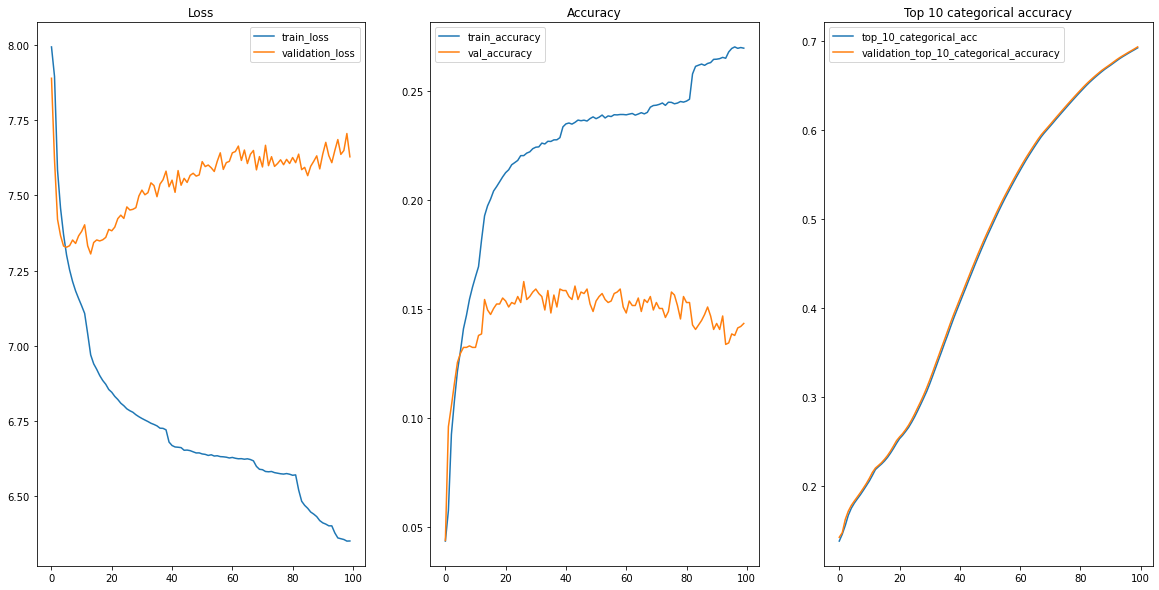

In [89]:
graph(results2)

From the graphs we can see this model is performing a lot better. As our epochs increase, there is over a 90% chance that out target is in the top 5 predicted words. There is very little variance in the validation and train set. 

## Model 5 (Best Model)

Adding more nodes in the LSTM layer and changing the optimizer to adam

In [183]:
model5 = Sequential()
model5.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model5.add(Dropout(0.2))
model5.add(LSTM(512))
model5.add(Dropout(0.3))
model5.add(Dense(y.shape[1], activation='relu'))
model5.add(Activation("softmax"))
print(model5.summary())

# optimizer = RMSprop(learning_rate=0.001)

model5.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)


checkpoint5 = ModelCheckpoint("nextword5.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

results5=model5.fit(X,y, epochs=150, batch_size=64, callbacks=[checkpoint5], validation_split=0.05).history

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 3, 512)            12883968  
_________________________________________________________________
dropout_53 (Dropout)         (None, 3, 512)            0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_54 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 5778)              2964114   
_________________________________________________________________
activation_23 (Activation)   (None, 5778)              0         
Total params: 17,947,282
Trainable params: 17,947,282
Non-trainable params: 0
_________________________________________

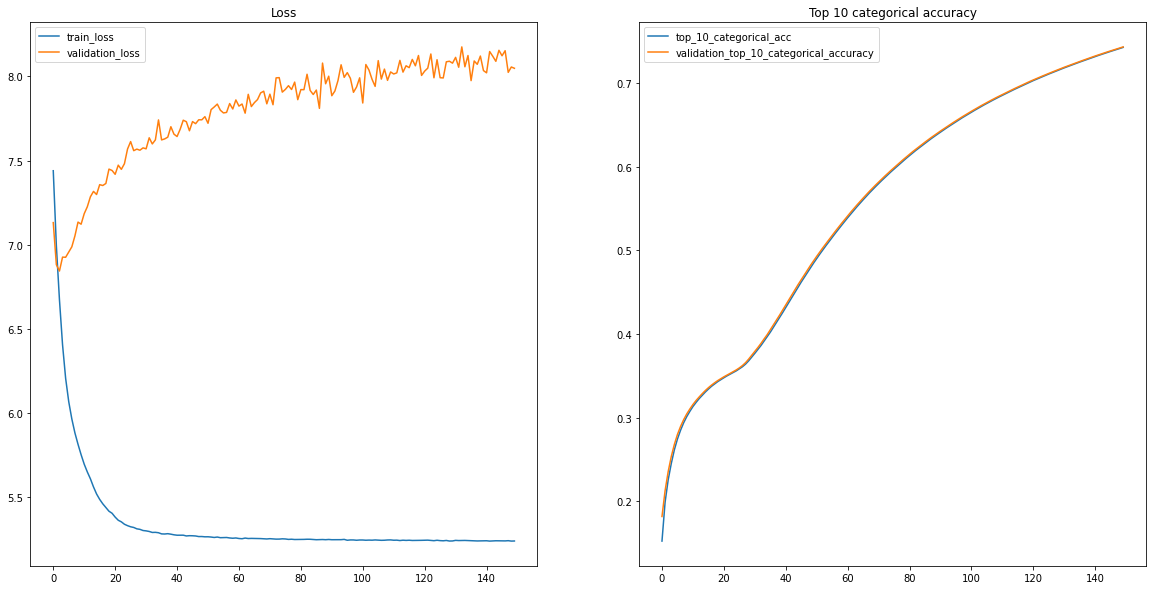

In [186]:
graph(results5)

## Model 6

Adding another LSTM with 256 nodes and Dropout layer

In [139]:
model6 = Sequential()
model6.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model6.add(Dropout(0.2))
model6.add(LSTM(256, return_sequences=True))
model6.add(Dropout(0.2))
model6.add(LSTM(256))
model6.add(Dropout(0.2))
model6.add(Dense(y.shape[1], activation='relu'))
model6.add(Activation("softmax"))
print(model6.summary())

optimizer = RMSprop(learning_rate=0.001)

model6.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)


checkpoint6 = ModelCheckpoint("nextword6.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

results6=model6.fit(X,y, epochs=150, batch_size=64, validation_split=0.05, callbacks=[checkpoint6]).history

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 3, 256)            6179840   
_________________________________________________________________
dropout_38 (Dropout)         (None, 3, 256)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 3, 256)            525312    
_________________________________________________________________
dropout_39 (Dropout)         (None, 3, 256)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 5778)            

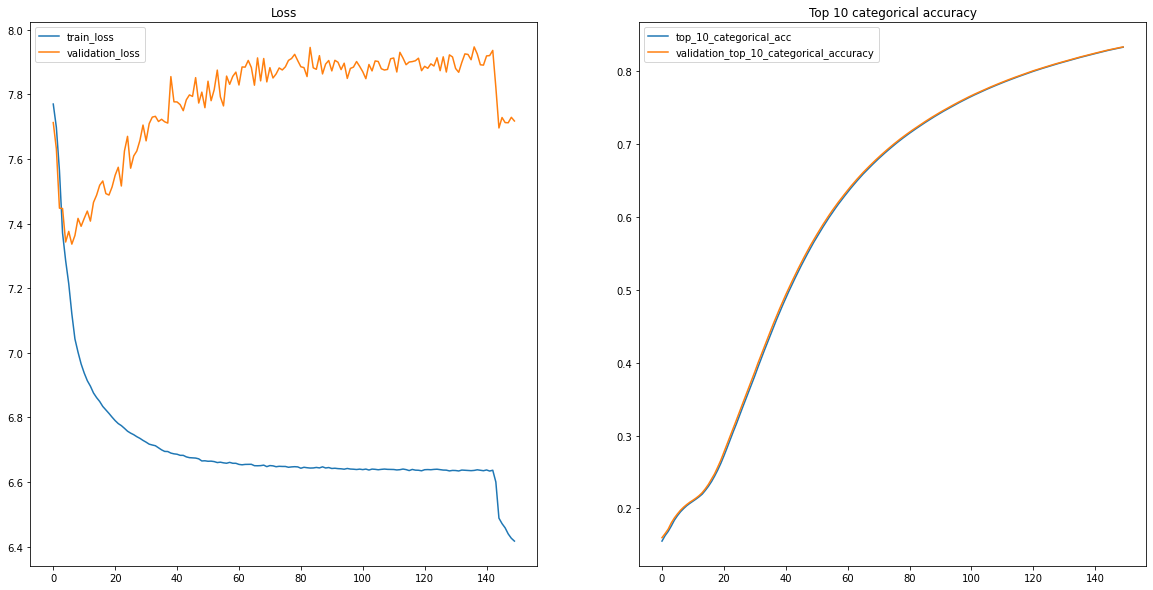

In [181]:
graph(results6)

There is no variance in the top k categorical accuracy measure. This model is giving over 80% accuracy if the target is in the top 5 predicted words. The loss has variance. 

## Model 7

Using 2 LSTM layers, with optimizer adam and making the Dense layer the output layer. 

In [169]:
model7 = Sequential()
model7.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model7.add(Dropout(0.2))
model7.add(LSTM(256))
model7.add(Dropout(0.2))
model7.add(Dense(y.shape[1], activation='softmax'))
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

checkpoint7 = ModelCheckpoint("nextword7.h5", monitor='loss', verbose=1, save_best_only=True, mode='min')

# fit the model
results7=model7.fit(X, y, epochs=100, batch_size=64, validation_split=0.05, callbacks=checkpoint7).history

Epoch 1/100
433/433 [==============================] - 8s 11ms/step - loss: 7.3905 - accuracy: 0.0409 - top_k_categorical_accuracy: 0.1509 - val_loss: 7.0053 - val_accuracy: 0.0576 - val_top_k_categorical_accuracy: 0.1702

Epoch 00001: loss improved from inf to 7.06865, saving model to nextword7.h5
Epoch 2/100
433/433 [==============================] - 4s 9ms/step - loss: 6.5181 - accuracy: 0.0670 - top_k_categorical_accuracy: 0.1751 - val_loss: 6.7823 - val_accuracy: 0.1310 - val_top_k_categorical_accuracy: 0.1924

Epoch 00002: loss improved from 7.06865 to 6.44812, saving model to nextword7.h5
Epoch 3/100
433/433 [==============================] - 4s 9ms/step - loss: 5.9713 - accuracy: 0.1448 - top_k_categorical_accuracy: 0.2003 - val_loss: 6.7122 - val_accuracy: 0.1495 - val_top_k_categorical_accuracy: 0.2198

Epoch 00003: loss improved from 6.44812 to 5.94355, saving model to nextword7.h5
Epoch 4/100
433/433 [==============================] - 4s 9ms/step - loss: 5.4980 - accuracy: 

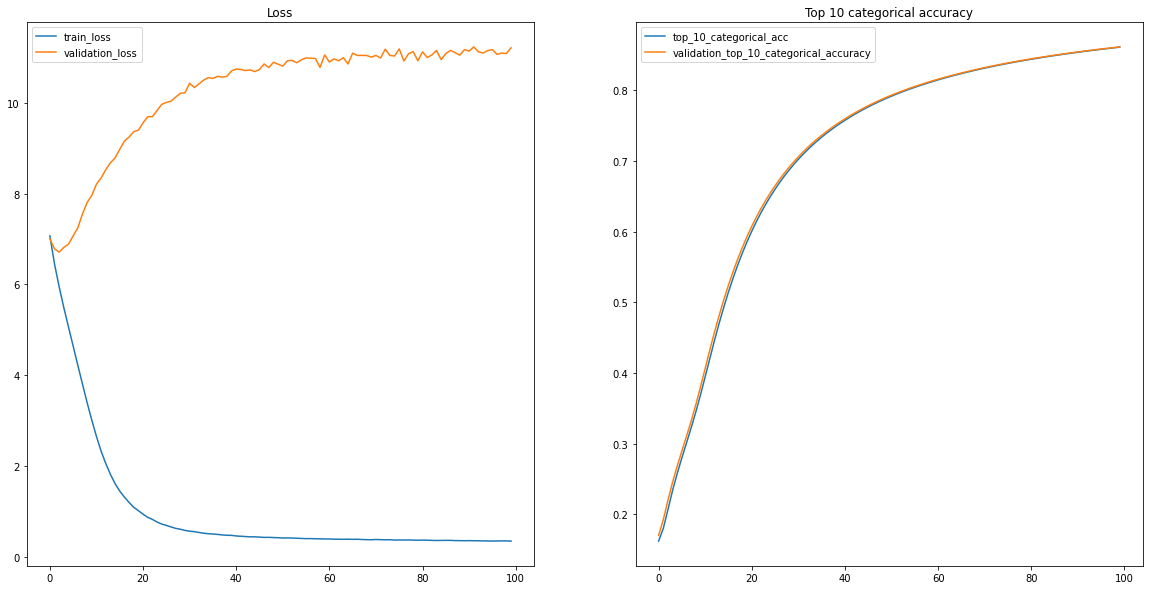

In [170]:
graph(results7)

There is a huge variance in the loss. The top k categorical accuracy is giving 80% results, with extremely small variance.

# Predictions

In [187]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
# prepare_input("کیلیفورنیا ریاستہائے متحدہ")

In [80]:
import heapq
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [81]:
def predict_completions(model, text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]


In [82]:
def predict(model):
  q =  input("ENTER TEXT: ")
  # print("correct sentence: ",q)
  seq =  q #" ".join(q)#tokenized.tokenize(q.lower())[0:3])
  print("Sequence: ",seq)
  print("next possible words: ", predict_completions(model, seq, 5))

Most of the models are giving the same words as predictions, in which 1-2 out of words are correct. Except the first simple model, model 5 and model 7, which is giving 3-4 out of 5 words correct.

The Final model to be used to make predictions is model5

In [178]:
predict(model5)

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['لیے', 'علاوہ', 'مقام', 'میں', 'کے']


In [108]:
predict(model5)

ENTER TEXT: ایران کا ایک
Sequence:  ایران کا ایک
ایران
کا
ایک
next possible words:  ['رہائشی', 'شہر', 'جو', 'اور', 'میں']


In [167]:
predict(model5)

ENTER TEXT: گرمیوں میں وہاں
Sequence:  گرمیوں میں وہاں
گرمیوں
میں
وہاں
next possible words:  ['کا', 'کی', 'پر', 'ریاستہائے', 'میں']


In [115]:
predict(model5)

ENTER TEXT: امریکا کا ایک
Sequence:  امریکا کا ایک
امریکا
کا
ایک
next possible words:  ['رہائشی', 'ہوائی', 'ٹاؤن', 'شہر', 'کاؤنٹی']


In [122]:
predict(model5)

ENTER TEXT: یہ اس سے
Sequence:  یہ اس سے
یہ
اس
سے
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [125]:
predict(model5)

ENTER TEXT: موجودگی کا پتہ
Sequence:  موجودگی کا پتہ
موجودگی
کا
پتہ
next possible words:  ['ٹاؤن', 'علاقہ', 'ء', 'آ', 'آئر']


In [126]:
predict(model5)

ENTER TEXT: اس لیے ان
Sequence:  اس لیے ان
اس
لیے
ان
next possible words:  ['پر', 'کا', 'صوبہ', 'میں', 'کی']


In [146]:
predict(model5)

ENTER TEXT: کے لیے استعمال
Sequence:  کے لیے استعمال
کے
لیے
استعمال
next possible words:  ['کیا', 'کی', 'ایک', 'ہے', 'میں']
